# Python Astro Photo processing

Welcome to this project about processing astro photos with Python. This project aims to correct errors in photographs taken near a source of light pollution, such as a city, and to improve the quality of the image.

In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Chargement de l'image

# INPUT_FILE = 'img/input/barnard_stacked_gradient.png'
INPUT_NAME = "barnard_stacked_gradient.png"
INPUT_FILE = f"img/gradient/{INPUT_NAME}"

img = cv2.imread(INPUT_FILE)

True

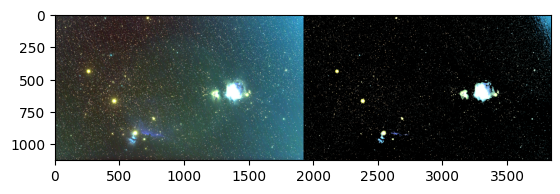

In [9]:
# Method 1 : Value threshold (HSV)

# Advantages: Easy to implement, fast, works well in most cases
# Disadvantages: Can remove bright pixels in the image

OUTPUT_FILE = f'img/output/{INPUT_NAME}_value_threshold.png'


# ----------------------------

def value_threshold(mask_val:int):
    mask = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Filter out brightest pixels
    mask = cv2.inRange(mask, (0, 0, 0), (255, 255, mask_val))

    # Substract mask from image
    mask = cv2.bitwise_not(mask)
    res = cv2.bitwise_and(img, img, mask=mask)
    return res


res = value_threshold(180)
plt.imshow(np.hstack([img, res]))

cv2.imwrite(OUTPUT_FILE, res)


# # save img to output folder
# cv2.imwrite(OUTPUT_FILE, res)

# Generate frames
# RANGE = range(0,255)
# frames = []
# for i in RANGE:
#     print(i)
#     MAX_VAL = i
#     res = value_threshold(MAX_VAL)
#     frames.append(res)

# # Generate gif
# from PIL import Image
# frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
# frames[0].save('img/output/barnard_stacked_gradient_threshold.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)


In [5]:
# Method 2 : Edge detection surface removal

# Advantages: 
# Disadvantages:

# ----------------------------



In [6]:
# Method 3 : Manual point input (interpolation)

# Advantages: Quick
# Disadvantages: Not accurate, manual input

OUTPUT_FILE = 'img/output/barnard_stacked_gradient_manual.png'
matplotlib.use('TkAgg')

# ----------------------------


plt.imshow(img)
plt.show()
points = plt.ginput(4)
# print(points)
plt.close()

# Get color of each point
colors = []
for point in points:
    colors.append(img[int(point[1]), int(point[0])])

# Interpolate for whole image
res = img.copy()
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        for k in range(3):
            res[i, j, k] = np.interp(img[i, j, k], [colors[0][k], colors[1][k]], [0, 255])

# Convert res colorspace
res = cv2.cvtColor(res, cv2.COLOR_BGR2HSV)


# save img to output folder
cv2.imwrite(OUTPUT_FILE, res)

IndexError: list index out of range

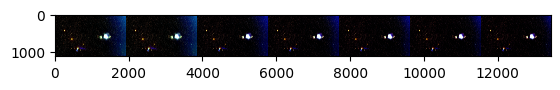

In [19]:
"""SobelGradientInterp

Advantages: very precise
Disadvantages: slow, poor performance on images with lots of objects

Method: Compute the edges of the image with laplacian, then blur the computed mask.
        Then, detect the larges area (empty space) in the mask and use that as the
        background. Finally, use the background to interpolate the gradient of the
        image.
"""

# Method 4 : Sobel gradient interpolation

# Advantages: very precise
# Disadvantages: slow, poor performance on images with lots of objects

# ----------------------------

OUTPUT_FILE = 'img/output/barnard_stacked_gradient_sobel_2.png'

def sobel_gradient_interp(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute edges
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)



    # Blur edges
    blur = cv2.GaussianBlur(laplacian, (5, 5), 0)


    # Find largest area
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find largest contour
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour

    # Create mask
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)


    # Get background color
    background = cv2.bitwise_and(img, img, mask=mask)
    background = cv2.cvtColor(background, cv2.COLOR_BGR2HSV)
    background = np.mean(background, axis=(0, 1))

    # Interpolate for whole image
    res = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(3):
                res[i, j, k] = np.interp(img[i, j, k], [background[k], 255], [0, 255])

    # Convert res colorspace
    # res = cv2.cvtColor(res, cv2.COLOR_BGR2HSV)

    # save img to output folder
    # cv2.imwrite(OUTPUT_FILE, res)

    # Show plot
    # plt.imshow(np.hstack((img, res)))
    return res

# Execute 5 passes of sobel gradient interpolation
res = img.copy()
res_arr = [res]
for i in range(5):
    res_arr.append(sobel_gradient_interp(res_arr[-1]))

plt.imshow(np.hstack((img, *res_arr)))

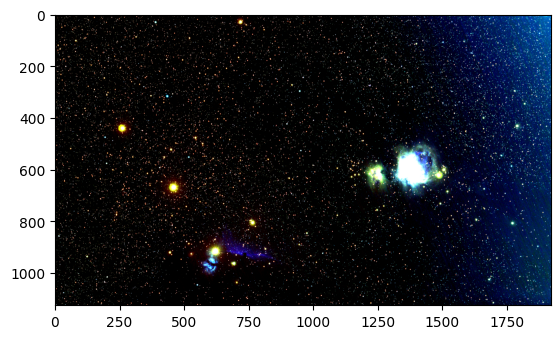

In [21]:
plt.imshow(img)

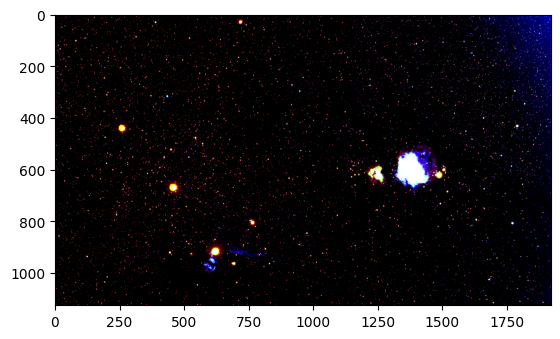

In [22]:
for i in range(5):
    res_arr.append(sobel_gradient_interp(res_arr[-1]))
print("Nombre de passes effecutées : ", len(res_arr))
plt.imshow(res_arr[-1])

Nombre de passes effecutées :  16


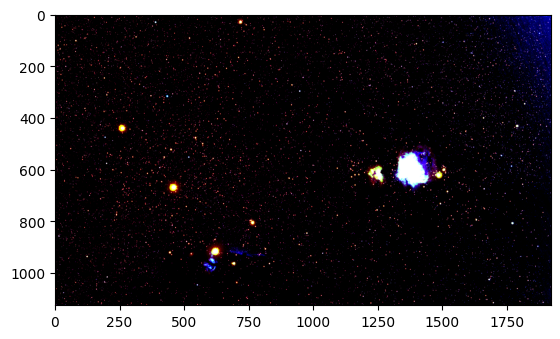

In [23]:
for i in range(5):
    res_arr.append(sobel_gradient_interp(res_arr[-1]))
print("Nombre de passes effecutées : ", len(res_arr))
plt.imshow(res_arr[-1])

In [24]:
# Save the computed res as a big hstacked image
cv2.imwrite('img/output/barnard_stacked_gradient_sobel_3.png', np.hstack((img, *res_arr)))

True

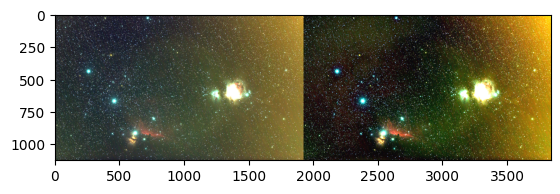

In [16]:
"""Alpha/Beta sliders

Advantages: Fast, generic, nice pre-processing step
Disadvantages: generic : not so well suited for some images

Method: Enhance the contrast of the image by using alpha/beta sliders
"""

# Method 5 : Alpha/Beta sliders


def alpha_beta_enhance(img, alpha, beta):
    res = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    return res



res = alpha_beta_enhance(img, 2, -100)
plt.imshow(np.hstack((cv2.cvtColor(img,cv2.COLOR_BGR2RGB) , res)))